# Forecasting Evaluation with Local Economic Variables

In this notebook, we collect and format the data for the project. We will be comparing the performance of forecasting models for stock percentage returns in the presence or absence of local economic data. 

Specifically, we will look at the percentage returns for PNC (Pittsburgh National Corporation), PPG (Pittsburgh Plate and Gas), and EQT (formerly Equitable Resources). Each of these corporations are primarily headquartered in Pittsburgh, PA. Stock returns will be used as a proxy for the financial health of the businesses. We will develop forecasting models for each of these stocks. In this project we will develop SARIMAX models, Tree models, LSTM models and a simple fully connected model.

In addition to utilizing the time series data, we will also utilize some "local" economic data. Since each of the corporations above are headquartered in Pittsburgh and are major employers of the region, it is hypothesized that the financial health of these businesses would influence the local economy. We will consider variables like median house price and monthly unemployment. Of course, the stock market is a global economic entity and stock prices are susceptible to a multitude of factors that are not local, but we would like to test if there is a geographic relationship between the stock prices and local economic factors.

As above, our primary purpose in this notebook is to collect and format the relevant data. After looking into available data sources one immediately runs into some issues. Stock prices are readily available via the yfinance API, housing prices are available via Zillow and unemployment are available via FRED. There are two 'scale' issues with the data: first, some variables are given as raw prices and unemployment is a percentage and second is that our local economic variables fail are calculated monthly while stocks are generally computed each business day. 

To overcome these issues, we will deal with price as a percentage change instead of raw values. While this reduces immediate interpretability of the financial data, it is not too hard to translate the percentage change into a raw dollar amount. The second and more limiting scale issue is the time series scale. We have a couple options to deal with this. 

1. Deal with monthly stock data by averaging.
2. Deal with daily economic data by simply using the monthly data as the daily data.
3. Interpolating the daily data via the monthly change.

We opt for option 1. The second option reduces the variance of the data considerably and may interfere with our deep learning models in the final notebook. The third option would induce serious bias in the daily data assuming we used a linear interpolation and an in depth interpolation method may interfere with our goal. The first option is not without issues either though. In particular, it severely reduces the number of data points from daily to monthly which leaves us with a reduced dataset for our deep learning models. In addition, it also flattens some of the noise in the data by averaging possibly hiding some quick fluctuations in the stocks.

Even with these drawbacks, the first option seems the most viable if we are simply testing our hypothesis above. The rest of the notebook will be collecting and formatting our data to fit the option above.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web

import matplotlib.pyplot as plt
import itertools
from scipy import stats

In [2]:
# Downloading the stock data from yfinance, each is stored as a dataframe in the list stocks

tickers = ["PNC", "PPG", "EQT"]

stocks = {}

for ticker in tickers:
    df = yf.download(ticker, start="2000-01-01", end="2025-07-31", interval="1d")
    stocks[ticker]=df[['Close']]
    
stock_data = pd.concat(stocks.values(), axis = 1)

C:\Users\benns\AppData\Local\Temp\ipykernel_6948\765359510.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2000-01-01", end="2025-07-31", interval="1d")
[*********************100%***********************]  1 of 1 completed
C:\Users\benns\AppData\Local\Temp\ipykernel_6948\765359510.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2000-01-01", end="2025-07-31", interval="1d")
[*********************100%***********************]  1 of 1 completed
C:\Users\benns\AppData\Local\Temp\ipykernel_6948\765359510.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2000-01-01", end="2025-07-31", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [3]:
#create the monthly average close prices dataframe and redo index to first of the month for compatibility reasons
stock_ma = stock_data.resample("M").mean()
stock_ma.index = stock_ma.index.to_period("M").to_timestamp()

C:\Users\benns\AppData\Local\Temp\ipykernel_6948\896935269.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  stock_ma = stock_data.resample("M").mean()


Now that we've downloaded and formatted our stock data, let's work on our local variable data. We'll collect monthly hourly wage and monthly unemployment data from FRED.

In [4]:
unemployment = web.DataReader("PITT342URN", 'fred', start = "2000-01-01", end = "2025-07-31")
unemployment = unemployment.resample("M").mean()
unemployment.index = unemployment.index.to_period("M").to_timestamp(how="start")


C:\Users\benns\AppData\Local\Temp\ipykernel_6948\853845882.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  unemployment = unemployment.resample("M").mean()


Lastly we will download the zillow data.

In [5]:
zillow = pd.read_csv("C:/Users/benns/Downloads/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv")
pitt_row = zillow[zillow["RegionName"] == "Pittsburgh, PA"]

pitt_row = pitt_row.drop(columns=["RegionName","RegionID", "SizeRank", "RegionType", "StateName"])
# Data is store as rows with dates as columns, so must reformat
pitt_col = pitt_row.T

pitt_col.columns = ["Median_Home_Value"]
# ensuring all data indexing is by datetime 
pitt_col.index = pd.to_datetime(pitt_col.index)

pitt_col = pitt_col[pitt_col.index > "1999-12-31"]

pitt_col.index = pitt_col.index.to_period("M").to_timestamp(how="start")


pitt_col.head

<bound method NDFrame.head of             Median_Home_Value
2000-01-01       88813.924596
2000-02-01       88257.033176
2000-03-01       88313.807333
2000-04-01       89144.697262
2000-05-01       90328.237482
...                       ...
2025-03-01      221789.471969
2025-04-01      224604.746764
2025-05-01      227694.025807
2025-06-01      230342.876943
2025-07-01      232771.348021

[307 rows x 1 columns]>

In [6]:
raw_data= pd.concat([stock_ma, unemployment, pitt_col], axis =1, join = "inner")

In [7]:
raw_data.columns = ["PNC", "PPG", "EQT", "Unemployment", "Med Home"]

Now we have all of the raw data. Let's look at the trend of the raw values.

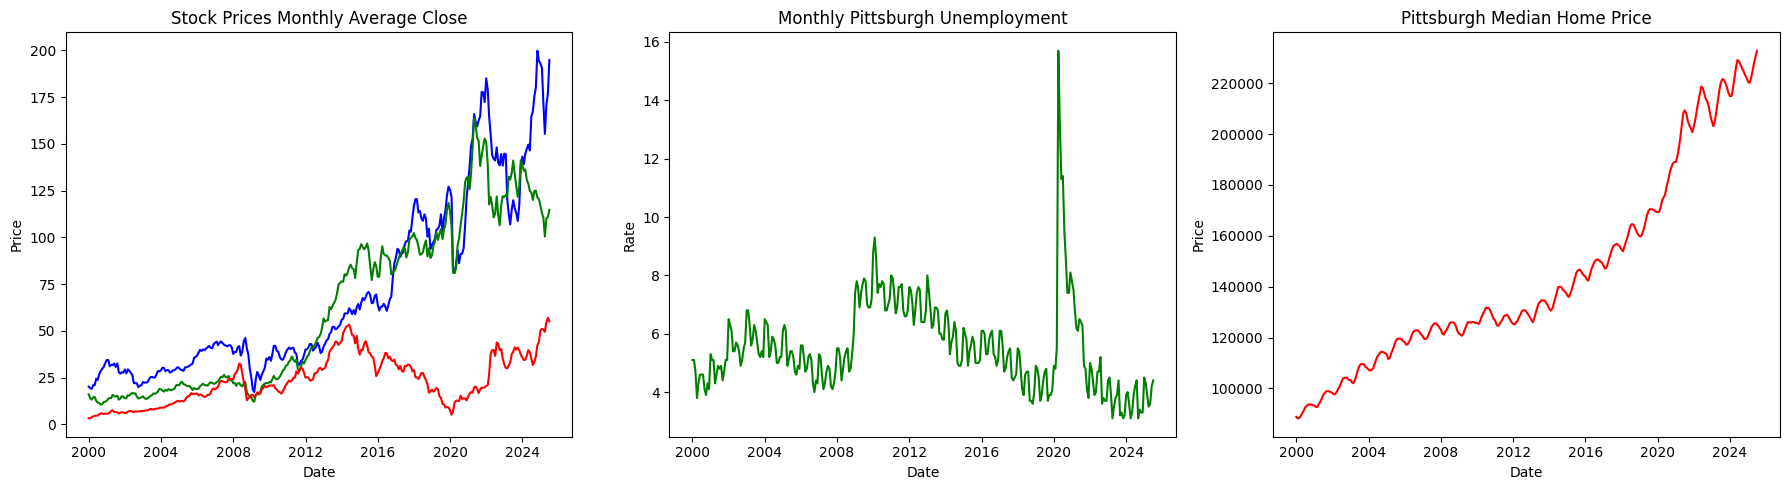

In [8]:
import matplotlib.pyplot as plt

# Assume your DataFrame is stock_un with columns 'PNC', 'PPG', 'EQT'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharex=False)

# Plot each series in its own subplot
axes[0].plot(raw_data.index, raw_data['PNC'], color='blue')
axes[0].plot(raw_data.index, raw_data['PPG'], color='green')
axes[0].plot(raw_data.index, raw_data['EQT'], color='red')
axes[0].set_title('Stock Prices Monthly Average Close')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')

axes[1].plot(raw_data.index, raw_data['Unemployment'], color='green')
axes[1].set_title('Monthly Pittsburgh Unemployment')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Rate')

axes[2].plot(raw_data.index, raw_data['Med Home'], color='red')
axes[2].set_title('Pittsburgh Median Home Price')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Price')

# Adjust layout so titles/labels don't overlap
plt.tight_layout()
plt.show()


Looking at the data, we notice some very clear trends. 

In 2008, we see a drop in all stock prices and a large spike in unemployment. This relates to the 2008 market crash, which was a perioud of high default among homebuyers and large stock losses. The crash seemed to cause a higher unemployment in Pittsburgh, but housing prices remained stable during this period.

In 2020, we see the effects of the COVID 19 pandemic. Financial stock dropped and then quickly rebounded while EQT, a natural gas company rebounded more slowly. The pandemic also caused mass unemployment in the Pittsburgh region and accelerated the median housing prices.

What else can we see from the data? It seems unemployment and median home price have some seasonal effects with the values oscillating somewhat between the values at the beginning of each year.

Now let's change from raw variables to percent changes in the data.

In [9]:
pct_change_data = raw_data.pct_change() * 100
pct_change_data = pct_change_data.dropna()
pct_change_data.head()

,PNC,PPG,EQT,Unemployment,Med Home
2000-02-01,-3.769677,-13.250999,-2.002493,0.000000,-0.627032
2000-03-01,-2.206935,-4.695125,17.302942,-7.843137,0.064328
2000-04-01,11.113336,8.827048,11.776062,-19.148936,0.940838
2000-05-01,-0.533925,1.906303,7.032762,13.157895,1.327662
2000-06-01,16.687651,-14.631165,2.186279,6.976744,1.124730


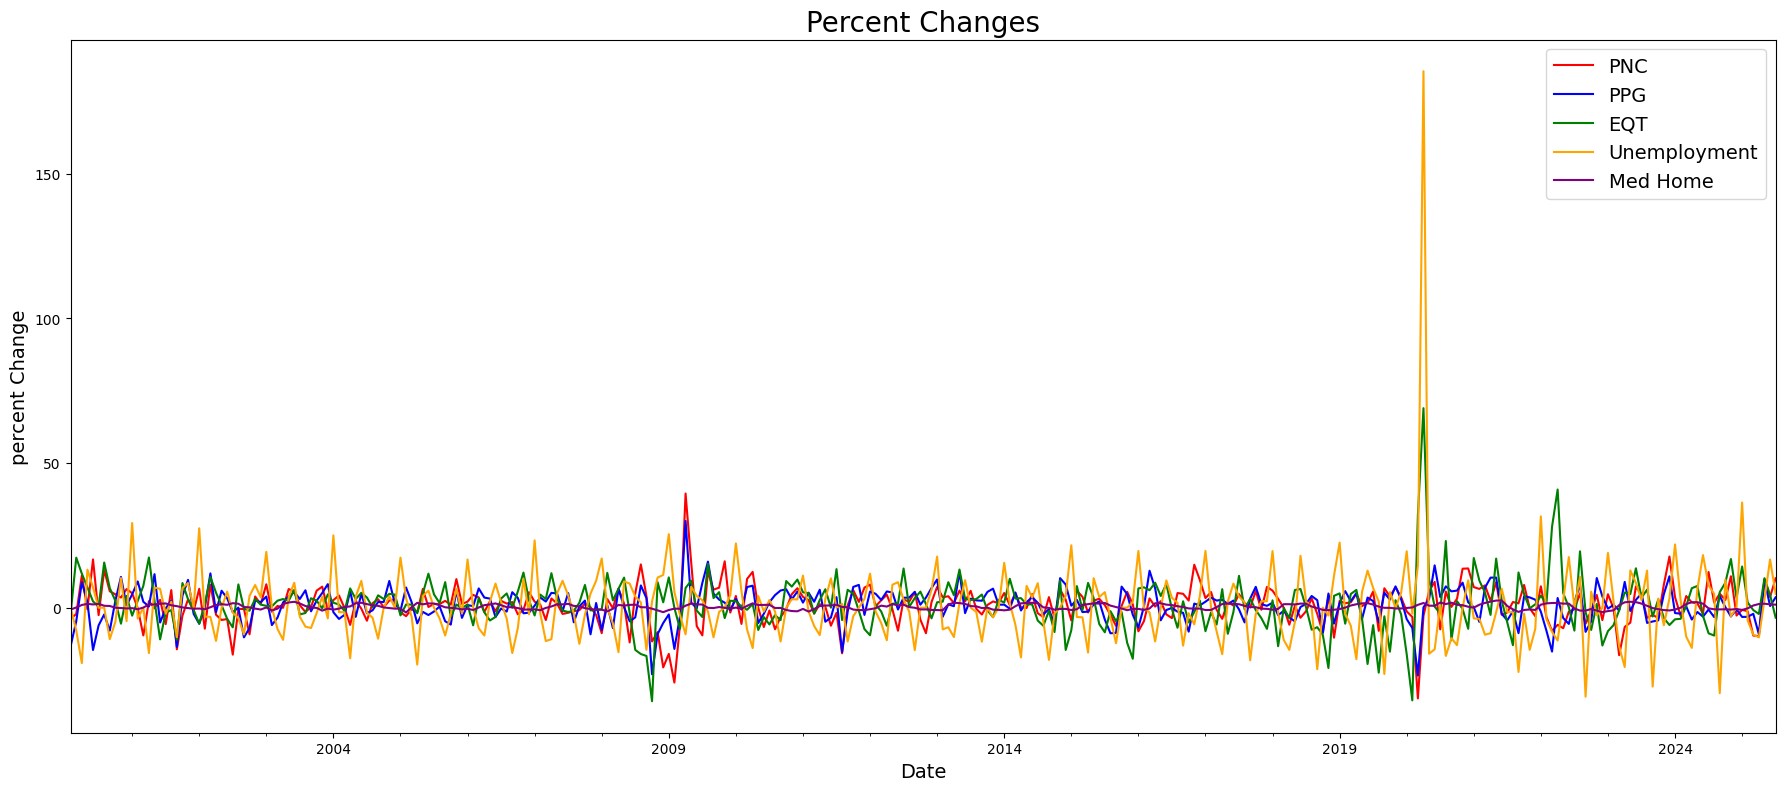

In [10]:
pct_change_data['PNC'].plot(figsize=(22,9), color ='red')
pct_change_data['PPG'].plot(color ='blue')
pct_change_data['EQT'].plot(color = 'green')
pct_change_data['Unemployment'].plot(color = 'orange')
pct_change_data['Med Home'].plot(color = 'purple')

plt.legend(['PNC', 'PPG', 'EQT', 'Unemployment', 'Med Home'], fontsize = 14)
plt.title('Percent Changes', fontsize = 20)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('percent Change', fontsize = 14)

plt.show()

When looking at percent changes, we can see that the data is relatively stationary. The largest spikes in percent changes come from unemployment, capping out at around 200 percent during the beginning of the COVID 19 pandemic. But even diregarding this, the unemployment percent changes are among the tallest spikes on the graph. 

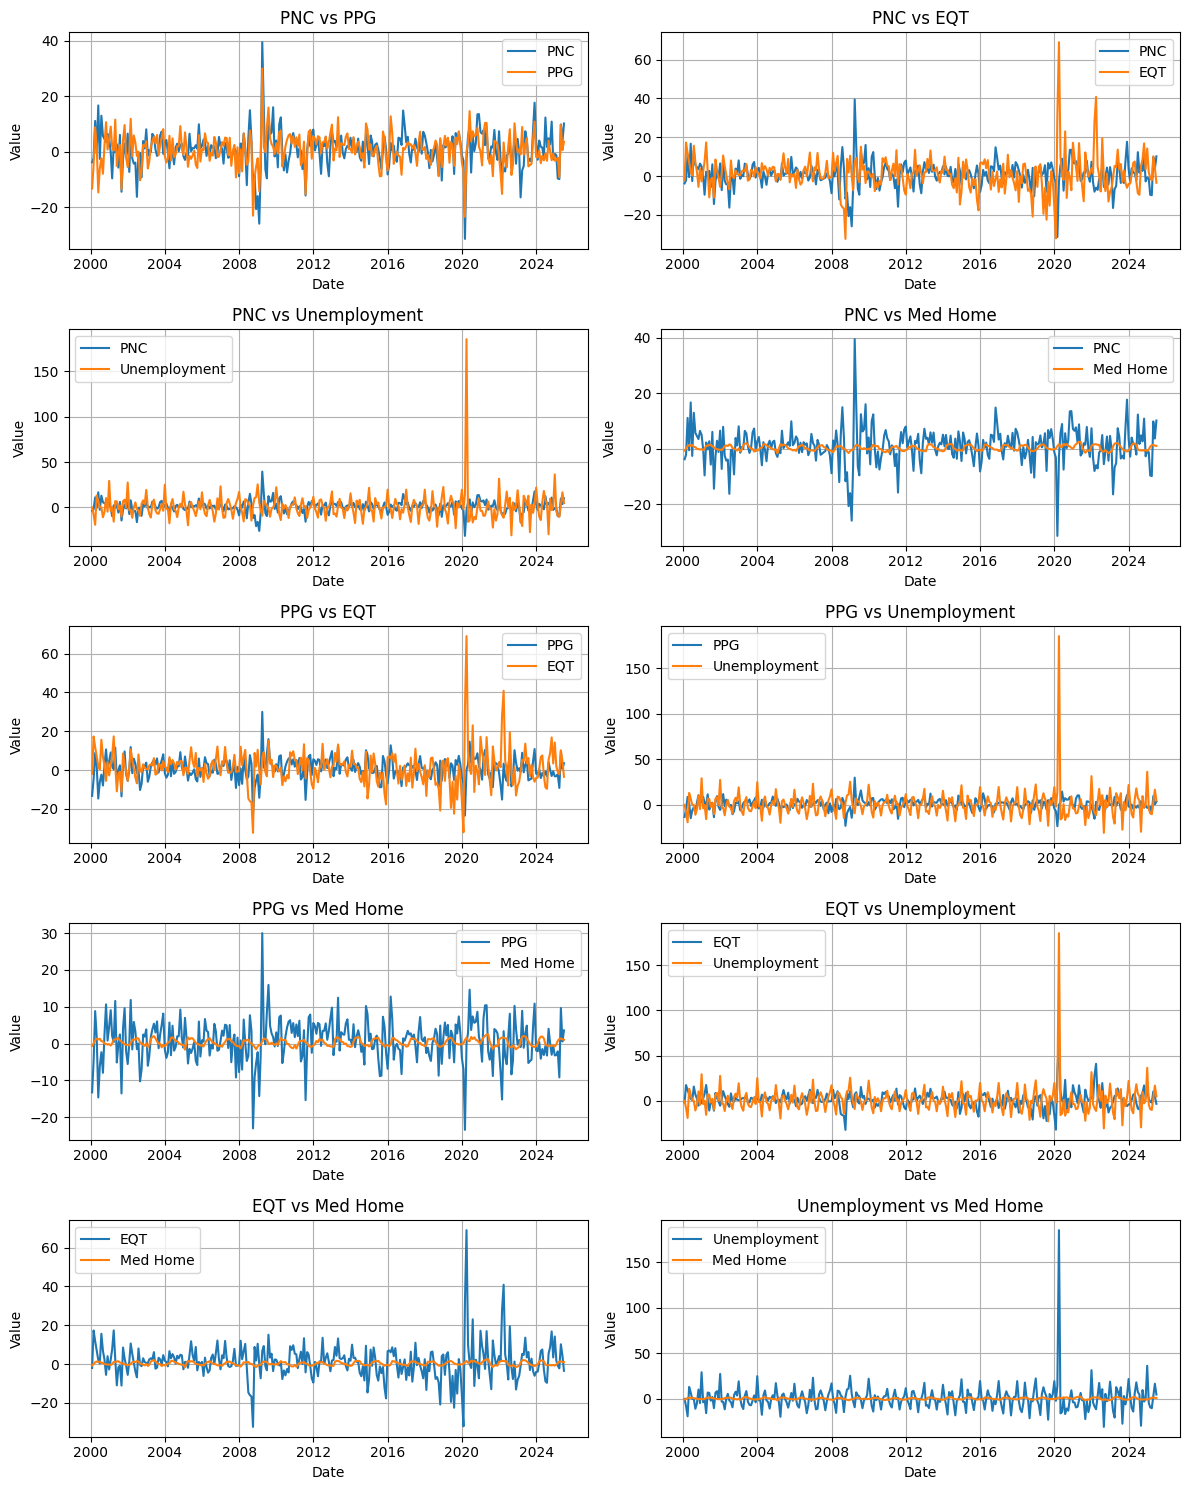

In [11]:
columns = pct_change_data.columns

pairs = list(itertools.combinations(columns, 2))
n_pairs = len(pairs)


ncols = 2
nrows = (n_pairs+ncols-1)//ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows*3))
axes = axes.flatten() 

for i, (x_var, y_var) in enumerate(pairs):
    axes[i].plot(pct_change_data.index, pct_change_data[x_var], label=x_var)
    axes[i].plot(pct_change_data.index, pct_change_data[y_var], label=y_var)
    axes[i].set_title(f"{x_var} vs {y_var}")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Value")
    axes[i].legend()
    axes[i].grid(True)

# Turn off any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Looking at the data in pairs, we can see that median home price percentage change is the time series with the least variance across all variable pairs. We also see the interesting effect that the PPG and PNC stock and the EQT stocks behave differently during the 2008 recession and the COVID 19 pandemic. PPG and PNC behave very similarly throughout the last 20 years.

Before moving onto modeling, lets the the QQ plots for each of the variables. 

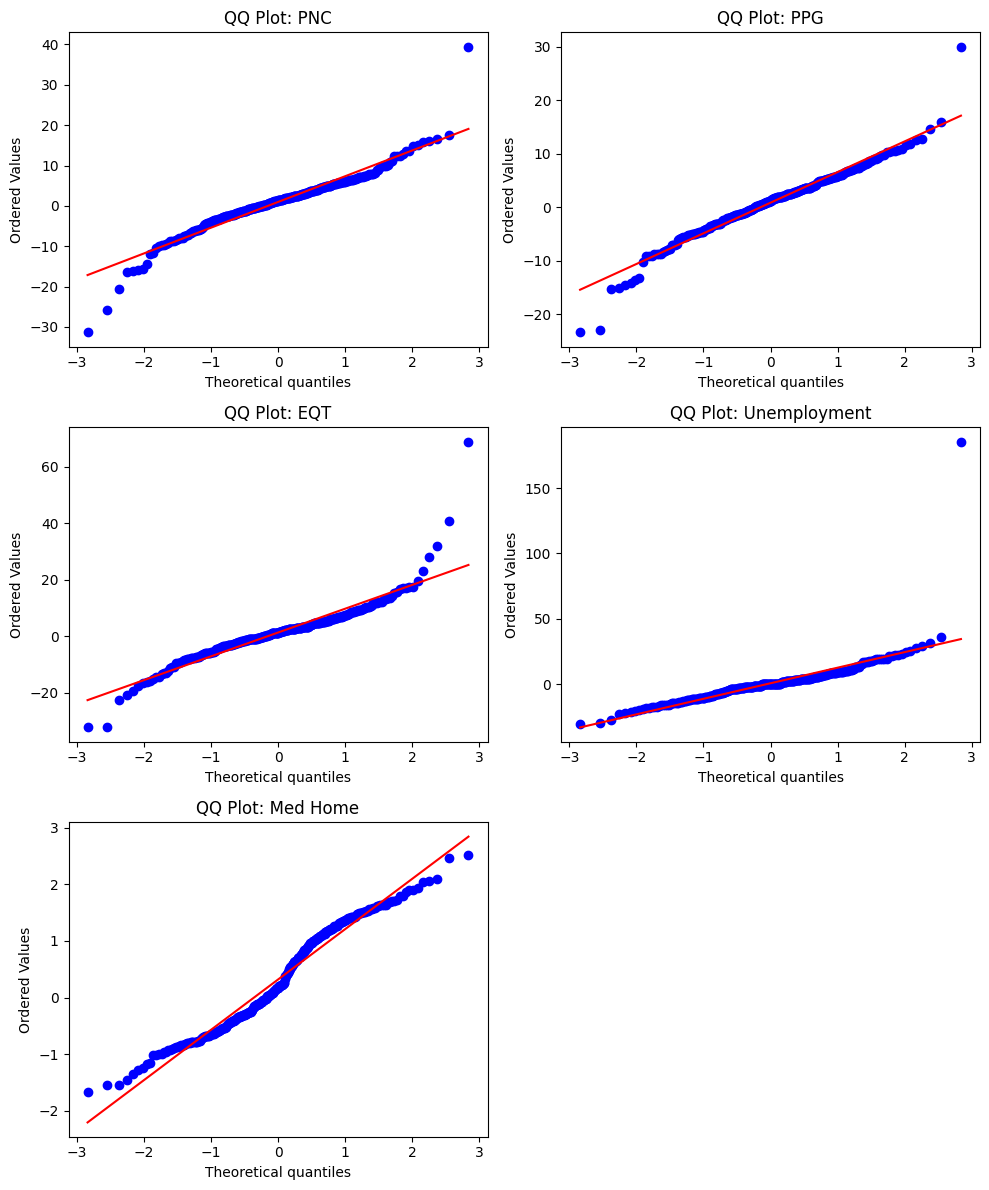

In [12]:
n_vars = len(columns)

ncols = 2
nrows = (n_vars + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows*4))
axes = axes.flatten()

for i, col in enumerate(columns):
    stats.probplot(pct_change_data[col], dist="norm", plot=axes[i])
    axes[i].set_title(f"QQ Plot: {col}")

# Turn off unused subplots if any
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Each of our stock averages are relative normal with the exception of a few outliers. Unemployment is also extremely normal excent for the large outlier more than likely induced by the COVID 19 Pandemic. Median home prices suffers from some skewnesss on both ends. One may want to use a boxcox transformation to flatten the tails of the distribution, but ultimately we will move on without doing so. 

Let's export as a CSV and move onto modeling with our data in the next notebook. We'll focus on SARIMAX models and tree based models for our data.

In [13]:
pct_change_data.index.name = 'Date'
pct_change_data.to_csv("formatted_data.csv", index=True)